# Kernel SHAP explanation for SVM models 

## Introduction

In this example, we show how to explain a multi-class classification model based on the SVM algorithm using the `KernelSHAP` method. We show how to perform instance-level (or *local*) explanations on this model as well as how to draw insights about the model behaviour in general by aggregating information from explanations across many instances (that is, perform *global explanations*).

In [1]:
import shap

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import svm
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
shap.initjs()

## Data preparation

In [2]:
wine = load_wine()
wine.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [3]:
data = wine.data
target = wine.target
target_names = wine.target_names
feature_names  = wine.feature_names

Split data into testing and training sets and normalize it.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 142
Testing records: 36


In [5]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

## Fitting a support vector classifier (SVC) to the Wine dataset

### Training 

<a id='intro'></a>

SVM, is a binary classifier, so multiple classifiers are fitted in order to support multiclass classification. The algorithm output is explained [here](#ovr_definition).

In [6]:
classifier = SVC(
    kernel = 'rbf', 
    C=1, 
    gamma = 0.1, 
    decision_function_shape='ovr',  # n_cls trained with data from one class as postive and remainder of data as neg
    random_state = 0, 
)
classifier.fit(X_train_norm, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

### Model assessment

Look at at average $10$-fold cross validation accuracy and at confusion matrix.

In [7]:
y_pred = classifier.predict(X_test_norm)

In [8]:
cm = confusion_matrix(y_test, y_pred)

In [9]:
accuracies = cross_val_score(estimator = classifier, 
                             X = X_train_norm,
                             y = y_train, 
                             cv = 10,
                            )
print("10-fold average accuracy:", accuracies.mean())

10-fold average accuracy: 0.9790476190476192


Text(0.5, 1.0, 'Confusion matrix for SVC classifier')

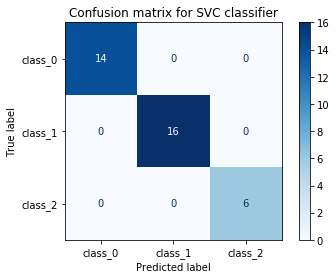

In [10]:
title = 'Confusion matrix for SVC classifier'
disp = plot_confusion_matrix(classifier, 
                             X_test_norm, 
                             y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

The confusion matrix show the classifier is perfect - let's understand what patterns in the data help the SVC perform so well!

## Apply KernelSHAP to explain the model

<a id='ovr_definition'></a>
The model needs access to a function that takes as an input samples and returns predictions to be explained. For an input $z$ the decision function of an _binary_ SVM classifier is given by: <br>
<h3 align="center"> $class(z) = \hat{\beta} z + \hat{b}$ </h3>
where $\beta$ is the best separating hyperplane (linear combination of support vectors, the training points closest to the separating hyperplane) and $b$ is the bias of the model. 

For the 'one-vs-rest' SVM, `nclass` binary SVM algorithms are fitted using each class as the positive class and the remainder as negative class. The classification decision is taken by assigning the label from the classifier with the maximum absolute decision score. Therefore, to explain our model we could consider explaining the SVM model which outputs the highest decision score. Click here to go back to [source](#intro).

To do so, the KernelSHAP explainer must receive a callable that returns a set of scores when called with an input $X$, in this case the `decision_function` attribute of our classifier. 

In [11]:
pred_fcn = classifier.decision_function
svm_explainer = shap.KernelExplainer(pred_fcn, X_train_norm)

Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<a id='source_1'></a>
Note that the explainer is initialised with the classifier training set . This training set is used for two purposes:
   - To determine the model output when all inputs are missing ($\phi_0$ in eq. $(5)$ of [1](#References). Because the SVM model does not accept arbitrary inputs, this quantity is approximated by averaging the decision score for each class, across the samples in `X_train_norm` as shown below and it is stored as the `expected_value` attribute of the explainer
   - The values of the features in `X_train_norm` are used to replace the values missing during the feature attribution ($\phi_i$) estimation process. `nsamples` cofies of `X_train_norm` are tiled to create a dataset where subsets of features will be set to *missing values* in order to estimate the contribution of a subset of features.
    
For the above reason, this is sometimes referred to as the *background dataset*; a larger dataset increases the runtime of the algorithm, so for large datasets, a subset of it should be used. An option to deal with the runtime issue while still providing meaningful values for missing values is to summarise the dataset using the `shap.kmeans` function. This function wraps the `sklearn` k-means clustering implementation, while ensuring that the clusters returned have values that are found in the training data. In addition, the samples are weighted according to the cluster sizes. 

In [12]:
# expected_values attribute stores average scores across training set for every binary SVM 
mean_scores_train = pred_fcn(X_train_norm).mean(axis=0)
# are stored in the expected value attibute of the explainer ...
print(mean_scores_train - svm_explainer.expected_value)  

[-1.11022302e-16  4.44089210e-16 -4.44089210e-16]


In [13]:
svm_shap_values = svm_explainer.shap_values(X_test_norm)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


Note that because of the dimensionality of the feature is small in this case. In cases where the feature space has higher dimensionality, sparse explanations ...

### Local explanation

Because the SVM algorithm returns a score for each of the $3$ classes, the shap_values are computed for each class in turn. Moreover, the attributions are computed for each data point to be explained and for each feature, resulting in a $N \times F$ matrix of shap values for each classs, where $N$ is the number of instances to be explained and $F$ is the number of features.

In [14]:
print("Output type:", type(svm_shap_values))
print("Output size:", len(svm_shap_values))
print("Class output size:", svm_shap_values[0].shape)

Output type: <class 'list'>
Output size: 3
Class output size: (36, 13)


For a given instance, we can visualise the attributions using a force plot. Let's choose the first example in the testing set as an example.

In [16]:
idx =  0
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)
scores =  classifier.decision_function(instance)
print("The predicted class for the X_test_norm[{}] is {}.".format(idx, *pred))
print("OVR decision function values are {}.".format(*scores))

The predicted class for the X_test_norm[0] is 0.
OVR decision function values are [ 2.24071294  0.85398239 -0.21510456].


We see that class $0$ is predicted because the SVM model trained with class $0$ as a positive class and classes $1$ and $2$ combined as a negative class returned the largest score.

To create this force plot, we have provided the plotting function with four inputs:
- the expected predicted score by the class-0 SVM assuming all inputs are missing. This is marked as the base value on the force plot
- the feature attributions for the instance to be explained 
- the instance to be explained 
- the feature names

In [17]:
shap.force_plot(
    svm_explainer.expected_value[pred.item()], 
    svm_shap_values[pred.item()][idx, :] , 
    instance,  
    feature_names,
)

The force plot depicts the contribution of each feature to the process of moving the value of the decision score from the _base value_ (estimation of the decision score if all inputs were missing) to the value predicted by the classifier. We see that all features contribute to increasing the decision score, and that the largest increases are due to the `proline` feature with a value of `1.049` and the `flavanoids` feature with a value of `0.9778`. The lengths of the bars are the corresponding feature attributions.

In [18]:
idx =  0
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)
scores =  classifier.decision_function(instance)
print("The predicted class for the X_test_norm[{}] is {}.".format(idx, *pred))
print("OVR decision function values are {}.".format(*scores))

The predicted class for the X_test_norm[0] is 0.
OVR decision function values are [ 2.24071294  0.85398239 -0.21510456].


Similarly, below we see that the `proline` and `alcohol` features contribute the to decreasing the decision score of the   `class-2` SVM and that the `malic_acid` feature increases the decision score.

In [19]:
shap.force_plot(
    svm_explainer.expected_value[1], 
    svm_shap_values[1][idx, :] , 
    instance,  
    feature_names,
)

An alternative way to visualise the multiouput model predictions is the _multioutput decision plot_. This plot is useful when the number of features is large so clear display in a force plot is not possible. 

Plot SHAP values for observation #2 using shap.multioutput_decision_plot. The plot's default base value is the average of the multioutput base values. The SHAP values are adjusted accordingly to produce accurate predictions. The dashed (highlighted) line indicates the model's predicted class. For this observation, the model is confident that disease is present, but it cannot easily distinguish between classes 3, 4, and 5.


In [75]:
def class_labels(classifier, instance, class_names=None):
    """
    Creates a set of legend labels based on the decision 
    scores of a classifier and, optionally, the class names.
    """

    decision_scores = classifier.decision_function(instance)
    
    if not class_names:
        class_names = ['Class {}'.format(i) for i in range(decision_scores.shape[1])]
    
    for i, score in enumerate(np.nditer(decision_scores)):
        class_names[i] = class_names[i] + ' ({})'.format(round(score.item(),3))
        
    return class_names
        

In [76]:
legend_labels = class_labels(classifier, instance)

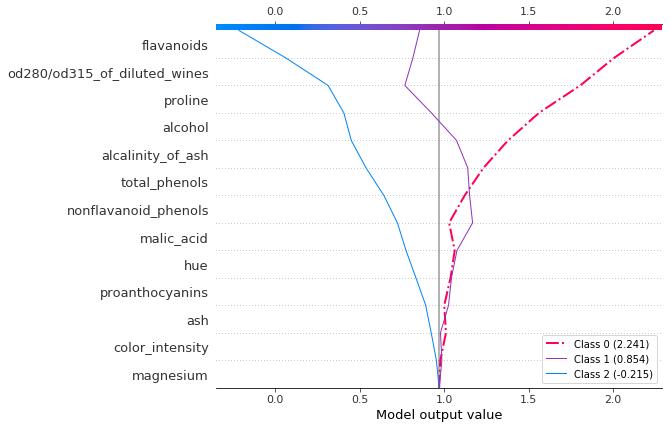

In [83]:
r = shap.multioutput_decision_plot(svm_explainer.expected_value.tolist(), 
                                   svm_shap_values,
                                   idx, 
                                   feature_names=feature_names, 
                                   feature_order='importance',
                                   highlight=[pred.item()],
                                   legend_labels=legend_labels,
                                   return_objects=True,
                                   legend_location='lower right')    

The decision plot shows that higher values of features such as `ash`, `hue` `malic acid` explain why this example was not classified as class `2`. We can also see that the `alcohol` feature has little effect on the prediction of the wine of not being class `2` but a more significant effect on the prediction of the wine of not being in `class 1` and being an even stronger predictor for a class 0 wine.

Note that the feature ordering is determined by summing the shap value magnitudes corresponding to each feature across classes and then ordering the `feature_names` in descending order of cumulative magniture. The plot origin, marked by the gray vertical line, is the average base values across the classes. The dashed line represents the model prediction - in general we can highlight a particular class by passing the class index in the `highlight` list.

Suppose now that we want to analyse instance `5` but realise that the feature importances are different for this instance.

In [91]:
idx =  5
instance = X_test_norm[idx][None, :]
pred = classifier.predict(instance)

In [92]:
instance_shap = np.array(svm_shap_values)[:, idx, :]
feature_order = np.argsort(np.sum(np.abs(instance_shap),axis=0))[::-1]
feat_importance = [feature_names[i] for i in feature_order]

In [93]:
print(feat_importance)

['flavanoids', 'alcalinity_of_ash', 'od280/od315_of_diluted_wines', 'alcohol', 'ash', 'total_phenols', 'proline', 'proanthocyanins', 'magnesium', 'hue', 'malic_acid', 'nonflavanoid_phenols', 'color_intensity']


We want to create a multi-output decision plot with the same feature order and scale. This is possible, since by passing the `return_objects=True` to the plotting function, we can retrieve the feature indices and the axis limits from the original plot.

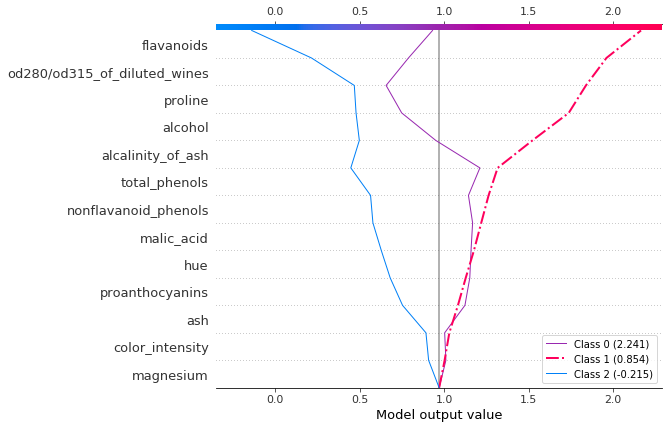

In [96]:
r = shap.multioutput_decision_plot(svm_explainer.expected_value.tolist(), 
                                   svm_shap_values,
                                   idx, 
                                   feature_names=feature_names, 
                                   feature_order=r.feature_idx,
                                   highlight=[pred.item()],
                                   legend_labels=legend_labels,
                                   legend_location='lower right',
                                   xlim=r.xlim,
                                   return_objects=False)    

### Global explanation

As shown above, the force plot allows us to understand how the individual features contribute to a classification output *given* an instance. However, the particular explanation does not tell us about the model behaviour in general. Below, we show how such insights can be drawn.

#### Stacked force plots

The simplest way we can do this is to stack the force plot for a number of instances, which can be achieved by calling the `force_plot` function with the same arguments as before but replacing `instance` with the whole testing set, `X_test_norm`.

In [21]:
class_idx = pred.item() # we explain the predicted label
shap.force_plot(
    svm_explainer.expected_value[class_idx], 
    svm_shap_values[class_idx], 
    X_test_norm,  
    feature_names,
)

In the default configuration, the `x` axis is represented by the `36` instances in `X_test_norm` whereas the `y` axis represents the decision score. Note that, like before, the decision score is for the class represented by `class_idx`. For a given instance, the height in between is equal to the shap value of the feature; as before, the blue shading shows a negative contribution to the decision score (moves the score *away* from the baseline value) whereas the pink shading shows a positive contribution to the decision score. The plot, tells us, for example, that to achieve a high decision score (equivalent to `class_idx` membership) the features `flavanoids` and `proline` are the most important.

We might be interested to look for correlations in the decision score and the values. This can be observed by permuting the `x` axis so that the instances are sorted according to the value of a desired feature. In the example below, I selected the `proanthocyanins` feature from the drop down menu to achieve this. We observe a mild positive correlation between this feature and the score, although the effect of this feature on the output value is small (i.e., feature not shown when hovering over the plot).

In [22]:
shap.force_plot(
    svm_explainer.expected_value[class_idx], 
    svm_shap_values[class_idx], 
    X_test_norm,  
    feature_names,
)

We can also explore the effect of a particular feature across our testing dataset. In the plot below, the instances are ordered on the  `x` axis in increasing value of the `flavanoids` feature. We see that the effect of this feature increases as its value increases.

In [23]:
shap.force_plot(
    svm_explainer.expected_value[class_idx], 
    svm_shap_values[class_idx], 
    X_test_norm,  
    feature_names,
)

In [30]:
feat_idx = feature_names.index('flavanoids')
instance_idx = 8
shap_val = svm_shap_values[class_idx][instance_idx, feat_idx]
print("For instance_idx {} the value of feature {} is {}".format(instance_idx, feat_idx, X_test_norm[instance_idx, feat_idx]))
print("For instance_idx {} the shap value of feature {} is {}".format(instance_idx, feat_idx, shap_val ))
print("For instance_idx {}, the decision score for class_idx {} is {}".format(instance_idx, 
                                                                       class_idx,
                                                                       pred_fcn(X_test_norm[instance_idx,  :][None, :]).squeeze()[class_idx]))
instance_idx = 2
shap_val = svm_shap_values[class_idx][instance_idx, feat_idx]
print("For instance_idx {} the value of feature {} is {}".format(instance_idx, feat_idx, X_test_norm[instance_idx, feat_idx]))
print("For instance_idx {} the shap value of feature {} is {}".format(instance_idx, feat_idx, shap_val ))
print("For instance_idx {}, the decision score for class_idx {} is {}".format(instance_idx, 
                                                                       class_idx,
                                                                       pred_fcn(X_test_norm[instance_idx][None, :]).squeeze()[class_idx]))


For instance_idx 8 the value of feature 6 is 0.08313300051349212
For instance_idx 8 the shap value of feature 6 is 0.07938284518628377
For instance_idx 8, the decision score for class_idx 0 is 0.8180729921712563
For instance_idx 2 the value of feature 6 is 1.183414193720803
For instance_idx 2 the shap value of feature 6 is 0.16064013105536035
For instance_idx 2, the decision score for class_idx 0 is 0.8645918444738925


In [25]:
# TODO: decide what to do about this!

However, we also notice that the `y` values of the individual instances do not correspond to their shap values. This is potentially a bug in the visualisatio tool.

#### Summary plots

To visualise the impact of the features on the decision scores associated with class `class_idx`, we can use a summary plot. In this plot, the features are sorted by the sum of their SHAP values magnitudes across all instances in `X_test_norm`. Therefore, the features with the highest impact on the decision score for class `class_idx` are displayed at the top of the plot.

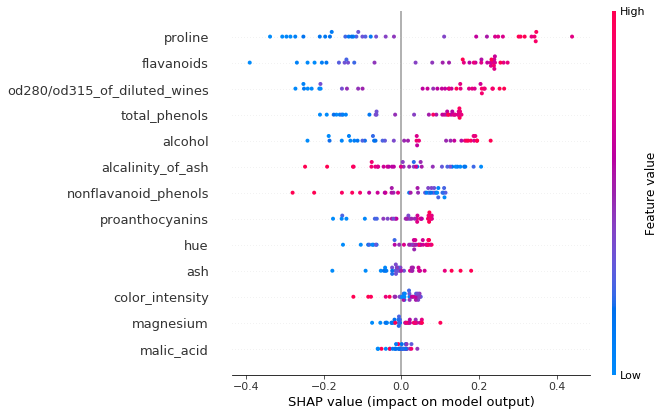

In [26]:
shap.summary_plot(svm_shap_values[class_idx], X_test_norm, feature_names)

In this case, the `proline` and `flavanoids` have the most impact on the model output; as the values of the features, their impact on model output also increases, making the model more likely to predict class `class_idx`. On the other hand, high values of the `nonflavonoid_phenols` have a negative impact on the model output, potentially contributing to the classification of the particular wine in a different class. To see this, we do a summary plot with respect to `class_1`.

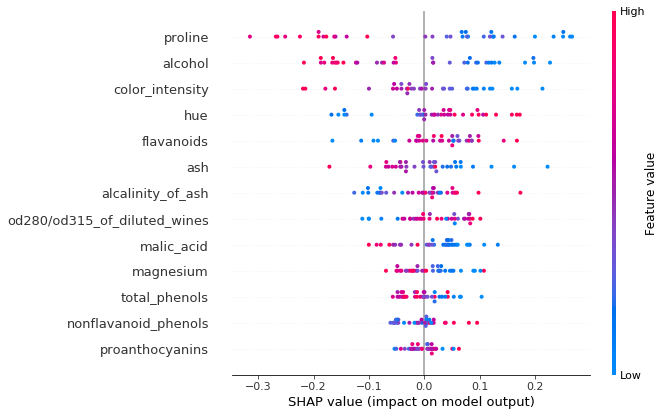

In [27]:
shap.summary_plot(svm_shap_values[1], X_test_norm, feature_names)

We see that, indeed, a higher value of the `nonflavonoid_phenols` feature contributes to a sample being classified as `class_1`, but that this effect is rather limited compared to features such as `proline` or `alcohol`.

To visualise the impact of the feature across all classes, that is, the importance of a particular feature for the model, we simply pass all the shap values to the `summary_plot` functions. We see that, for example, the `color_intensity` feature is much more important for deciding whether an instance should be classified as `class_2` then in `class_1` (see also the individual plots for `class_0` and `class_1` above).

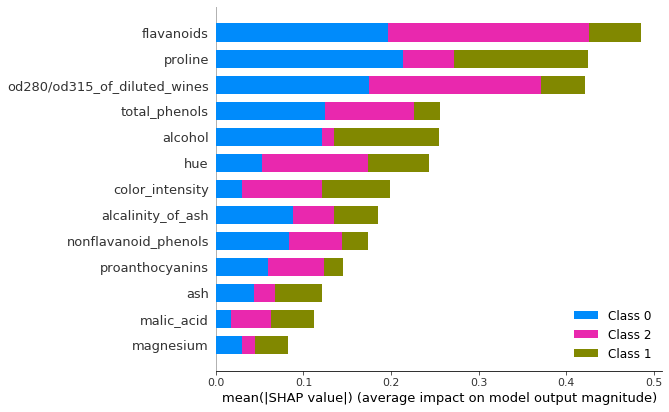

In [28]:
shap.summary_plot(svm_shap_values, X_test_norm, feature_names)

#### Dependence plots

Another way to visualise the model dependence on a particular feature is through a dependence plot. This plot shows the impact of the feature value on its importance for classification with respect to `class_idx`.

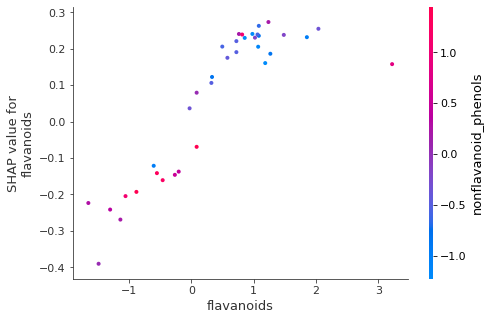

In [29]:
feature = 'flavanoids'
shap.dependence_plot(
    feature, 
    svm_shap_values[class_idx], 
    X_test_norm, 
    feature_names=feature_names,
    interaction_index='auto',
)

The colour of the individual instances is represented by the value of the feature `nonflavanoid_phenols`. By specifying `interaction_index=auto`, the `nonflavanoid_phenols` was estimated as a the feature with the strongest interaction with the `flavanoids_feature`; this interaction is approximate, and is estimate by computing the Pearson Correlation Coefficient between the shap values of the reference feature (`flavanoids` in this case) and the value of each feature in turn on bins along the feature value. 

We see that a higher value for `nonfavanoid_phenols` is generally associated with a low value in `flavanoids` and has a negative impact on the score for `class_idx` classification.

### References

<a id='References'></a>
[1](#source_1) *[1] Lundberg, S.M. and Lee, S.I., 2017. A unified approach to interpreting model predictions. In Advances in neural information processing systems (pp. 4765-4774).*

# TODO

- Look at this and give some explanation about background data https://github.com/slundberg/shap/issues/922
- Have a look at this example to see if you get further inspiration 